In [1]:
import h5py
import pandas as pd
import csv
import numpy as np

# Read csv and extract site-specific embedding
def extract_embedding(protein_id, site, h5_file_path):
    with h5py.File(h5_file_path, 'r') as h5_file:
        if protein_id not in h5_file:
            return None  # Protein ID not found, return None
        dataset = h5_file[protein_id]
        if site-1 >= dataset.shape[0] or site <= 0:
            return None  # Site index is out of bounds, return None

        embedding = dataset[site-1]
        return embedding.flatten()

def load_site_information(input_csv_path, output_csv_path, h5_file_path):
    df = pd.read_csv(input_csv_path)
    protein_ids = df['accession'].values
    sites = df['site'].values
    count = 0
    
    with open(output_csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        # Write header if file is empty
        if f.tell() == 0:
            writer.writerow(['protein_id', 'site', 'embedding'])
        
        for (protein_id, site) in zip(protein_ids, sites):
            embedding = extract_embedding(protein_id, site, h5_file_path)
            count += 1
            if embedding is not None:
                # Convert embedding array to a space-separated string
                embedding_str = ' '.join(map(str, embedding))
                writer.writerow([protein_id, site, embedding_str])    
                print(f"{count}. {protein_id},{site}")
            else:
                print(f"{count}. Embedding not found for {protein_id} at site {site}")

if __name__ == '__main__':
    print("Loading ESM2 embeddings for train_pos dataset")
    load_site_information('data/info/positive_sites.csv',
                          'Embeddings/ESM_650/train_pos_esm650.csv', 'ESM2_650_embeddings_D2.h5')
    print("Loading ESM2 embeddings for train_neg dataset")
    load_site_information('data/info/negative_sites.csv',
                          'Embeddings/ESM_650/train_neg_esm650.csv', 'ESM2_650_embeddings_D2.h5')
    print("Loading ESM2 embeddings for test_pos dataset")
    load_site_information('data/info/test_positive_sites.csv',
                          'Embeddings/ESM_650/test_pos_esm650.csv', 'ESM2_650_embeddings_D2.h5')
    print("Loading ESM2 embeddings for test_neg dataset")
    load_site_information('data/info/test_negative_sites.csv',
                          'Embeddings/ESM_650/test_neg_esm650.csv', 'ESM2_650_embeddings_D2.h5')


Loading ESM2 embeddings for train_pos dataset
1. P0A823,227
2. P75863,344
3. P0ABS8,7
4. P0ABS8,74
5. P0A7D7,3
6. P0A7D7,52
7. P0A7D7,203
8. P0A7D7,157
9. P0A7D7,13
10. P0A7D7,163
11. P0A7D7,103
12. P0A7D7,152
13. P0A8E7,159
14. P0A8E7,90
15. P0A8E7,108
16. Q47147,50
17. Q47147,115
18. P11458,77
19. P11458,179
20. P0A7P5,11
21. P12996,103
22. P0AC92,7
23. P0AC92,53
24. P00452,584
25. P00452,723
26. P00452,727
27. P00452,9
28. P0AE63,61
29. P0AE63,37
30. P0AE63,26
31. P76108,127
32. P76108,119
33. P63235,489
34. P25524,110
35. P25524,207
36. P24228,98
37. P00961,565
38. P00961,146
39. P00961,592
40. P00961,584
41. P00961,607
42. P00961,624
43. P00961,214
44. P00961,674
45. P00961,72
46. P00961,86
47. P00961,282
48. P00961,286
49. P09394,188
50. P09394,127
51. P09394,140
52. P09394,173
53. P02359,35
54. P02359,17
55. P02359,131
56. P02359,171
57. P02359,149
58. P77754,43
59. P77754,135
60. P0A8I3,209
61. P00561,5
62. P00561,415
63. P00561,770
64. P39838,96
65. P76550,209
66. P76550,117
6

In [3]:
from sklearn.model_selection import train_test_split
#Read csv 
train_pos = pd.read_csv('Embeddings/Prot_t5/train_pos_t5.csv')
train_neg = pd.read_csv('Embeddings/Prot_t5/train_neg_t5.csv')
test_pos = pd.read_csv('Embeddings/Prot_t5/test_pos_t5.csv')
test_neg = pd.read_csv('Embeddings/Prot_t5/test_neg_t5.csv')

#Concatenate positive and negative datasets and add labels
train_pos['label'] = 1
train_neg['label'] = 0
train = pd.concat([train_pos, train_neg])
test_pos['label'] = 1
test_neg['label'] = 0
test = pd.concat([test_pos, test_neg])

print(train.shape)
print(test.shape)

from Bio import SeqIO

# For protein_id and site, get the sequence from the FASTA file
def get_sequence(protein_id, site, fasta_file, window_size=32, pad_char='-'):
    with open(fasta_file) as fasta:
        for record in SeqIO.parse(fasta, 'fasta'):
            if record.id == protein_id:
                seq = record.seq
                site = int(site)

                # Calculate start and end indices
                start = max(0, site - window_size - 1)
                end = min(len(seq), site + window_size)

                # Extract the sequence
                extracted_seq = str(seq[start:end])

                # Calculate padding needed on the left and right
                left_padding = max(0, window_size - site +1)
                right_padding = max(0, (site + window_size) - len(seq))

                # Add padding if necessary
                padded_seq = (pad_char * left_padding) + extracted_seq + (pad_char * right_padding)

                return padded_seq
    return None


# Get sequence for train and test datasets and add to dataframe
train['sequence'] = train.apply(lambda x: get_sequence(x['protein_id'], x['site'], 'data/full_sequences/all_sequence_cleaned.fasta'), axis=1)
test['sequence'] = test.apply(lambda x: get_sequence(x['protein_id'], x['site'], 'data/full_sequences/all_sequence_cleaned.fasta'), axis=1)

amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'

# Drop rows with amino acids not in the list
train = train[train['sequence'].apply(lambda x: all(aa in amino_acids for aa in x))]
test = test[test['sequence'].apply(lambda x: all(aa in amino_acids for aa in x))]

train, val = train_test_split(train, test_size=0.1, random_state=42)

# Write train and test datasets to CSV
train.to_csv('Embeddings/D1/train_D1_65.csv', index=False)
val.to_csv('Embeddings/D1/val_D1_65.csv', index=False)
test.to_csv('Embeddings/D1/test_D1_65.csv', index=False)


(9347, 4)
(3226, 4)


Import Libraries:

In [2]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LayerNormalization, BatchNormalization, Activation
import os
import random
from  keras.regularizers import l2


Load Data:

In [64]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

#read train and test datasets

# train = pd.read_csv('Final dataset/final_train.csv')
# #make train balanced
# train_pos = train[train['label'] == 1]
# train_neg = train[train['label'] == 0].sample(n=len(train_pos), random_state=42)
# train = pd.concat([train_pos, train_neg])
# val = pd.read_csv('Final dataset/final_val.csv')
test = pd.read_csv('Final dataset/final_test.csv')

# train = pd.read_csv('Embeddings/ESM_650/train_esm650.csv')
# val = pd.read_csv('Embeddings/ESM_650/val_esm650.csv')
# test = pd.read_csv('Embeddings/ESM_650/test_esm650.csv')

# train_1 = pd.read_csv('Succinylation~1/Train/train_DBPTM.csv')
# val_1 = pd.read_csv('Succinylation~1/Train/val_DBPTM.csv')

train = pd.read_csv('Embeddings/Prot_t5/train_t5.csv')
val = pd.read_csv('Embeddings/Prot_t5/val_t5.csv')
# test = pd.read_csv('Embeddings/Prot_t5/test_t5.csv')

# train = pd.read_csv('Embeddings/D1/train_D1.csv')
# val = pd.read_csv('Embeddings/D1/val_D1.csv')
# test = pd.read_csv('Embeddings/D1/test_D1.csv')


print(train.shape)
print(val.shape)
print(test.shape)

# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_val_embeddings = val['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))
X_test_embeddings = test['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

# Convert to a numpy array if needed
X_train_embeddings = np.stack(X_train_embeddings.values)
X_val_embeddings = np.stack(X_val_embeddings.values)
X_test_embeddings = np.stack(X_test_embeddings.values)

# Extract sequences
X_train = train['sequence'].values
X_val = val['sequence'].values
X_test = test['sequence'].values

# Extract labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]
X_val_num = [[aa_to_int[aa] for aa in seq] for seq in X_val]
X_test_num = [[aa_to_int[aa] for aa in seq] for seq in X_test]

X_train_num = np.array(X_train_num)
X_val_num = np.array(X_val_num)
X_test_num = np.array(X_test_num)

#print shapes
print(X_train_embeddings.shape)
print(X_val_embeddings.shape)
print(X_test_embeddings.shape)
print(X_train_num.shape)
print(X_val_num.shape)
print(X_test_num.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)




(8411, 5)
(935, 5)
(3151, 5)
(8411, 1024)
(935, 1024)
(3151, 1024)
(8411, 33)
(935, 33)
(3151, 33)
(8411,)
(935,)
(3151,)


In [65]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [66]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, y_val=None):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    print(f'Accuracy: {accuracy}')
    print(f'MCC: {mcc}')
    print(f'AUC: {auc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Specificity: {specificity}')
    print(f'F1: {f1}')

    return accuracy, mcc, auc, precision, recall, specificity, f1

For ESM 3B model:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_31        │ (None, 33, 21)    │      1,344 │ input_layer_62[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_63      │ (None, 2560)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_62    │ (None, 33, 21)    │          0 │ embedding_31[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_133 (Dense)   │ (None, 64)        │    163,904 │ input_layer_63[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_165 (Conv1D) │ (None, 33, 32)    │        704 │ embedding_31[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_166 (Conv1D) │ (None, 33, 32)    │      2,048 │ embedding_31[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_167 (Conv1D) │ (None, 33, 32)    │      3,392 │ embedding_31[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_168 (Conv1D) │ (None, 33, 32)    │      4,736 │ embedding_31[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_169 (Conv1D) │ (None, 33, 32)    │        704 │ max_pooling1d_62… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_133[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_62      │ (None, 33, 160)   │          0 │ conv1d_165[0][0], │
│ (Concatenate)       │                   │            │ conv1d_166[0][0], │
│                     │                   │            │ conv1d_167[0][0], │
│                     │                   │            │ conv1d_168[0][0], │
│                     │                   │            │ conv1d_169[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_63    │ (None, 16, 160)   │          0 │ concatenate_62[0… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 32)        │      2,080 │ dropout_98[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_31          │ (None, 2560)      │          0 │ max_pooling1d_63… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_134[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_132 (Dense)   │ (None, 16)        │     40,976 │ flatten_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 220,321 (860.63 KB)

 Trainable params: 220,129 (859.88 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5109 - loss: 16.5939 - val_accuracy: 0.2607 - val_loss: 13.5892
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5363 - loss: 13.0032 - val_accuracy: 0.3717 - val_loss: 10.8280
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5789 - loss: 10.3416 - val_accuracy: 0.5319 - val_loss: 8.6536
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5989 - loss: 8.2967 - val_accuracy: 0.5852 - val_loss: 7.0008
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6044 - loss: 6.7646 - val_accuracy: 0.6243 - val_loss: 5.7308
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6397 - loss: 5.5360 - val_accuracy: 0.6590 - val_loss: 4.7231
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6579 - loss: 4.5778 - val_accuracy: 0.6767 - val_loss: 3.9462
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6818 - loss: 3.83

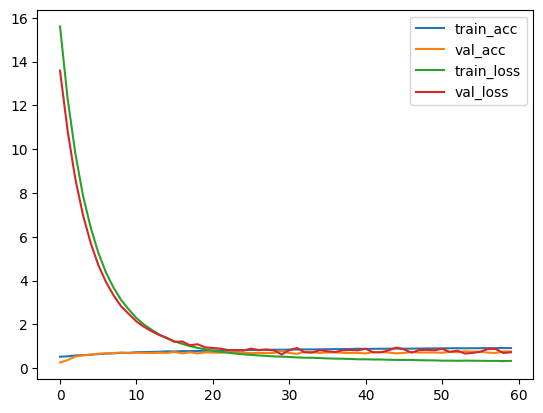

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.7276550998948476
MCC: 0.4696788394751282
AUC: 0.7315590111642742
Precision: 0.799492385786802
Recall: 0.6363636363636364
Specificity: 0.8267543859649122
F1: 0.7086614173228346
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7892126472411656
MCC: 0.2648873545878641
AUC: 0.7066350780210299
Precision: 0.20952380952380953
Recall: 0.6086956521739131
Specificity: 0.8045745038681467
F1: 0.3117408906882591


(0.7892126472411656,
 0.2648873545878641,
 0.7066350780210299,
 0.20952380952380953,
 0.6086956521739131,
 0.8045745038681467,
 0.3117408906882591)

In [94]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.regularizers import l2

def simplified_inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)



    # Branch 6: MaxPooling + Conv1D with kernel size 1
    branch5 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    branch5 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch5)

    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch5])
    return output

def build_simplified_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    # Apply simplified Inception module
    x_conv = simplified_inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Reduced Dense layer for sequence features with L2 regularization
    x_conv = Dense(16, activation='relu')(x_conv)
    # x_conv = Dropout(0.4)(x_conv)

    # Simplified ANN branch for ESM-2 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Reduced ANN layers for large embedding with L2 regularization
    x_ann = Dense(64, activation='relu', kernel_regularizer=l2(0.1))(ann_input)
    x_ann = BatchNormalization()(x_ann)
    x_ann = Dropout(0.6)(x_ann)
    x_ann = Dense(32, activation='relu', kernel_regularizer=l2(0.1))(x_ann)
    x_ann = BatchNormalization()(x_ann)
    x_ann = Dropout(0.6)(x_ann)

    # Concatenate Conv1D (Inception) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Final output layer
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Define the model with Conv1D input shape (33,) and ANN input shape 2560
simplified_model = build_simplified_model((33,), 2560)
simplified_model.summary()

# Fit the simplified model with reduced batch size for better generalization
history = simplified_model.fit([X_train_num, X_train_embeddings], y_train, epochs=1000, batch_size=64, verbose=1,
                               validation_data=([X_test_num, X_test_embeddings], y_test),
                               callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

plot(history)

# Evaluate the model
evaluate_model(simplified_model, X_val_num, X_val_embeddings, y_val)
evaluate_model(simplified_model, X_test_num, X_test_embeddings, y_test)


For Prot_t5 model:

Epoch 1/1000


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5572 - loss: 0.6837 - val_accuracy: 0.6727 - val_loss: 0.6475
Epoch 2/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6515 - loss: 0.6423 - val_accuracy: 0.7102 - val_loss: 0.6132
Epoch 3/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6781 - loss: 0.6135 - val_accuracy: 0.7337 - val_loss: 0.5847
Epoch 4/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6979 - loss: 0.5906 - val_accuracy: 0.7422 - val_loss: 0.5610
Epoch 5/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7159 - loss: 0.5703 - val_accuracy: 0.7487 - val_loss: 0.5397
Epoch 6/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7215 - loss: 0.5495 - val_accuracy: 0.7540 - val_loss: 0.5235
Epoch 7/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7412 - loss: 0.5350 - val_accuracy: 0.7594 - val_loss: 0.5136
Epoch 8/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7392 - loss: 0.5234 - val_accuracy

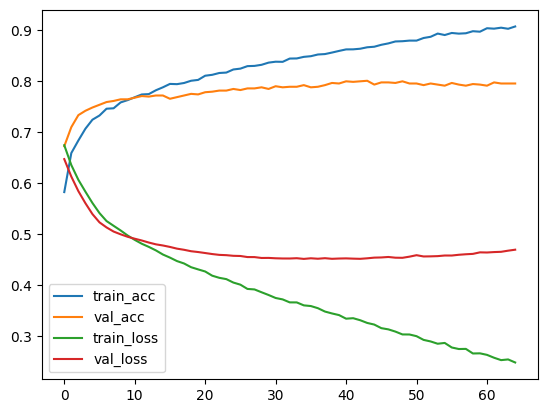

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.7925133689839572
MCC: 0.5836890761702792
AUC: 0.7918445380851397
Precision: 0.8036437246963563
Recall: 0.8036437246963563
Specificity: 0.780045351473923
F1: 0.8036437246963563
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7797524595366551
MCC: 0.3491675596784886
AUC: 0.7921358038581034
Precision: 0.22857142857142856
Recall: 0.8067226890756303
Specificity: 0.7775489186405767
F1: 0.3562152133580705


(0.7797524595366551,
 0.3491675596784886,
 0.7921358038581034,
 0.22857142857142856,
 0.8067226890756303,
 0.7775489186405767,
 0.3562152133580705)

In [67]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_tensor)

    # Branch 5: MaxPooling + Conv1D with kernel size 1
    branch5 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    branch5 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(branch4)

    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch5])
    return output

def build_inception_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(16, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features
    x_ann = Dense(64, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (Inception) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(16, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
inception_model = build_inception_model((33,), 1024)
# inception_model.summary()

# Fit the Inception model
history = inception_model.fit([X_train_num, X_train_embeddings], y_train, epochs=1000, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                            )

plot(history)

evaluate_model(inception_model, X_val_num, X_val_embeddings, y_val)
evaluate_model(inception_model, X_test_num, X_test_embeddings, y_test)


For ESM 650M model:

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 33, 21)    │      1,344 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 33, 21)    │          0 │ embedding_1[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 33, 16)    │        352 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 33, 16)    │      1,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 33, 16)    │      1,696 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 33, 16)    │      2,368 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 33, 16)    │        352 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 33, 80)    │          0 │ conv1d_7[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_8[0][0],   │
│                     │                   │            │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_10[0][0],  │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 16, 80)    │          0 │ concatenate_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1280)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │     20,496 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │     10,248 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 8)         │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 24)        │          0 │ dropout_5[0][0],  │
│ (Concatenate)       │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         25 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 37,969 (148.32 KB)

 Trainable params: 37,937 (148.19 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4995 - loss: 1.5132 - val_accuracy: 0.5146 - val_loss: 1.2985
Epoch 2/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5405 - loss: 1.4061 - val_accuracy: 0.5800 - val_loss: 1.2520
Epoch 3/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5537 - loss: 1.3363 - val_accuracy: 0.6004 - val_loss: 1.2122
Epoch 4/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5721 - loss: 1.2758 - val_accuracy: 0.5998 - val_loss: 1.1845
Epoch 5/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5966 - loss: 1.2152 - val_accuracy: 0.6135 - val_loss: 1.1444
Epoch 6/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6028 - loss: 1.1606 - val_accuracy: 0.6352 - val_loss: 1.1033
Epoch 7/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6135 - loss: 1.1274 - val_accuracy: 0.6401 - val_loss: 1.0731
Epoch 8/1000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6290 - loss: 1.0903 - val_accuracy: 0.

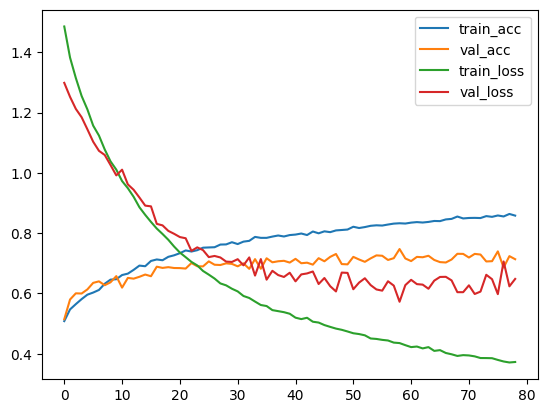

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7276550998948476
MCC: 0.4580178116076518
AUC: 0.7289673046251994
Precision: 0.7599118942731278
Recall: 0.696969696969697
Specificity: 0.7609649122807017
F1: 0.7270811380400422
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7473651580905145
MCC: 0.2629684350030531
AUC: 0.7200928248837695
Precision: 0.1912087912087912
Recall: 0.6877470355731226
Specificity: 0.7524386141944164
F1: 0.2992261392949269


(0.7473651580905145,
 0.2629684350030531,
 0.7200928248837695,
 0.1912087912087912,
 0.6877470355731226,
 0.7524386141944164,
 0.2992261392949269)

In [30]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

def inception_module(input_tensor):
    # Branch 1: Conv1D with kernel size 1
    branch1 = Conv1D(16, kernel_size=1, activation='relu', padding='same')(input_tensor)

    # Branch 2: Conv1D with kernel size 3
    branch2 = Conv1D(16, kernel_size=3, activation='relu', padding='same')(input_tensor)

    # Branch 3: Conv1D with kernel size 5
    branch3 = Conv1D(16, kernel_size=5, activation='relu', padding='same')(input_tensor)

    # Branch 4: Conv1D with kernel size 7
    branch4 = Conv1D(16, kernel_size=7, activation='relu', padding='same')(input_tensor)

    # Branch 7: MaxPooling + Conv1D with kernel size 1
    branch7 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    branch7 = Conv1D(16, kernel_size=1, activation='relu', padding='same')(branch7)

    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4, branch7])
    return output

def build_inception_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)

    # Embedding layer
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    # Apply Inception module instead of Conv1D
    x_conv = inception_module(x_conv)

    # MaxPooling and Flatten layers
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(8, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for esm_2 embeddings
    ann_input = Input(shape=(input_shape_ann,))

    # Simple Dense layer for ANN features
    # x_ann = Dense(64, activation='relu', kernel_regularizer = l2(0.02))(ann_input)
    # x_ann = BatchNormalization()(x_ann)
    # x_ann = Dropout(0.6)(x_ann)

    x_ann = Dense(16, activation='relu', kernel_regularizer = l2(0.02))(ann_input)
    x_ann = BatchNormalization()(x_ann)
    x_ann = Dropout(0.6)(x_ann)

    # Concatenate Conv1D (Inception) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Fully connected layers with Batch Normalization
    # x = Dense(16, activation='relu')(combined)
    # x = Dropout(0.3)(x)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

# Define the model with Conv1D input shape (33,) and ANN input shape 1280
inception_model = build_inception_model((33,), 1280)
inception_model.summary()

# Fit the Inception model
history = inception_model.fit([X_train_num, X_train_embeddings], y_train, epochs=1000, batch_size=128, verbose=1, shuffle=True,
                               validation_data=([X_test_num, X_test_embeddings], y_test),
                               callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])

# Plot the training history (replace `plot` with your own plotting function if needed)
plot(history)

# Evaluate the model
evaluate_model(inception_model, X_val_num, X_val_embeddings, y_val)
evaluate_model(inception_model, X_test_num, X_test_embeddings, y_test)


Residual Connections Model :

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5249 - loss: 0.6911 - val_accuracy: 0.6171 - val_loss: 0.6743
Epoch 2/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5821 - loss: 0.6750 - val_accuracy: 0.6556 - val_loss: 0.6512
Epoch 3/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6186 - loss: 0.6555 - val_accuracy: 0.6813 - val_loss: 0.6242
Epoch 4/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6309 - loss: 0.6370 - val_accuracy: 0.6963 - val_loss: 0.6009
Epoch 5/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6668 - loss: 0.6178 - val_accuracy: 0.7144 - val_loss: 0.5813
Epoch 6/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6774 - loss: 0.6071 - val_accuracy: 0.7422 - val_loss: 0.5589
Epoch 7/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6963 - loss: 0.5833 - val_accuracy: 0.7540 - val_loss: 0.5316
Epoch 8/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7140 - loss: 0.5668 -

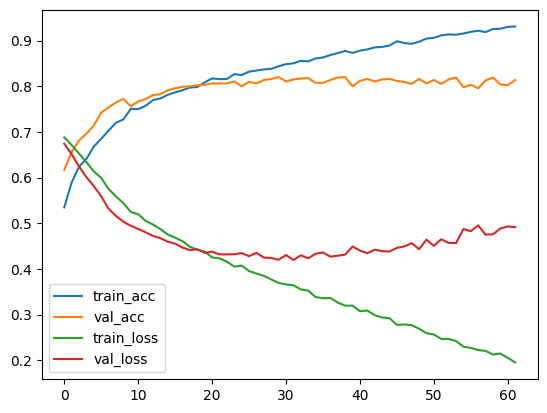

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.8149732620320855
MCC: 0.6289021108542063
AUC: 0.814559292002901
Precision: 0.8268839103869654
Recall: 0.8218623481781376
Specificity: 0.8072562358276644
F1: 0.8243654822335026
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8092668993970168
MCC: 0.3602225637470769
AUC: 0.7868775728623066
Precision: 0.2496551724137931
Recall: 0.7605042016806722
Specificity: 0.8132509440439409
F1: 0.37590861889927313


(0.8092668993970168,
 0.3602225637470769,
 0.7868775728623066,
 0.2496551724137931,
 0.7605042016806722,
 0.8132509440439409,
 0.37590861889927313)

In [86]:
import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

def residual_block(input_tensor, filters):
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)
    x = Concatenate()([x, input_tensor])  # Skip connection
    return x

def build_resnet_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)

    # Apply Residual blocks
    x_conv = residual_block(x_conv, 32)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = residual_block(x_conv, 64)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(32, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D (ResNet) and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(16, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
res_model = build_resnet_model((33,), 1024)
# inception_model.summary()

# Fit the Inception model
history = res_model.fit([X_train_num, X_train_embeddings], y_train, epochs=1000, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                            )

plot(history)

evaluate_model(res_model, X_val_num, X_val_embeddings, y_val)
evaluate_model(res_model, X_test_num, X_test_embeddings, y_test)


Simple Model:

Epoch 1/1000


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5437 - loss: 0.6885 - val_accuracy: 0.6182 - val_loss: 0.6616
Epoch 2/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6340 - loss: 0.6553 - val_accuracy: 0.6396 - val_loss: 0.6342
Epoch 3/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6565 - loss: 0.6319 - val_accuracy: 0.6642 - val_loss: 0.6116
Epoch 4/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6760 - loss: 0.6129 - val_accuracy: 0.6909 - val_loss: 0.5928
Epoch 5/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6878 - loss: 0.5984 - val_accuracy: 0.7059 - val_loss: 0.5781
Epoch 6/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6995 - loss: 0.5833 - val_accuracy: 0.7230 - val_loss: 0.5639
Epoch 7/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7159 - loss: 0.5683 - val_accuracy: 0.7316 - val_loss: 0.5478
Epoch 8/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7190 - loss: 0.5565 - val_accuracy:

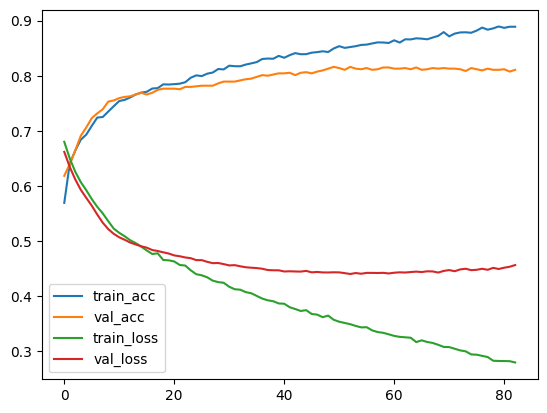

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.8160427807486631
MCC: 0.6305530647946924
AUC: 0.8144766678601265
Precision: 0.8156862745098039
Recall: 0.8421052631578947
Specificity: 0.7868480725623582
F1: 0.8286852589641435
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7819739765153919
MCC: 0.33719515955437623
AUC: 0.7798329424457734
Precision: 0.2258852258852259
Recall: 0.7773109243697479
Specificity: 0.7823549605217989
F1: 0.3500473036896878


(0.7819739765153919,
 0.33719515955437623,
 0.7798329424457734,
 0.2258852258852259,
 0.7773109243697479,
 0.7823549605217989,
 0.3500473036896878)

In [69]:
def build_simple_model(input_shape_conv, input_shape_ann):
    # Conv1D branch for sequence data
    conv_input = Input(shape=input_shape_conv)
    x_conv = Embedding(input_dim=64, output_dim=21, input_length=input_shape_conv[0])(conv_input)
    x_conv = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x_conv)
    x_conv = MaxPooling1D(pool_size=2)(x_conv)
    x_conv = Flatten()(x_conv)

    # Dense layer for sequence features
    x_conv = Dense(16, activation='relu')(x_conv)
    x_conv = Dropout(0.3)(x_conv)

    # ANN branch for prot_t5 embeddings
    ann_input = Input(shape=(input_shape_ann,))
    x_ann = Dense(32, activation='relu')(ann_input)
    x_ann = Dropout(0.3)(x_ann)

    # Concatenate Conv1D and ANN branches
    combined = Concatenate()([x_conv, x_ann])

    # Output layer
    x = Dense(16, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build model
    model = Model(inputs=[conv_input, ann_input], outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model




set_seed(4)

# Define the model with Conv1D input shape (33,) and ANN input shape 1024
simple_model = build_simple_model((33,), 1024)
# inception_model.summary()

# Fit the Inception model
history = simple_model.fit([X_train_num, X_train_embeddings], y_train, epochs=1000, batch_size=64, verbose=1,
                               validation_data=([X_val_num, X_val_embeddings], y_val),
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                            )

plot(history)

evaluate_model(simple_model, X_val_num, X_val_embeddings, y_val)
evaluate_model(simple_model, X_test_num, X_test_embeddings, y_test)

Epoch 1/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4657 - loss: 0.8202 - val_accuracy: 0.4652 - val_loss: 0.7305
Epoch 2/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5270 - loss: 0.7081 - val_accuracy: 0.5807 - val_loss: 0.6402
Epoch 3/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6318 - loss: 0.6152 - val_accuracy: 0.7080 - val_loss: 0.5761
Epoch 4/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7400 - loss: 0.5509 - val_accuracy: 0.7711 - val_loss: 0.5311
Epoch 5/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7814 - loss: 0.5007 - val_accuracy: 0.7925 - val_loss: 0.4998
Epoch 6/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8112 - loss: 0.4662 - val_accuracy: 0.8064 - val_loss: 0.4772
Epoch 7/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8256 - loss: 0.4396 - val_accuracy: 0.8043 - val_loss: 0.4612
Epoch 8/1000
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8377 - loss: 0.4173 - 

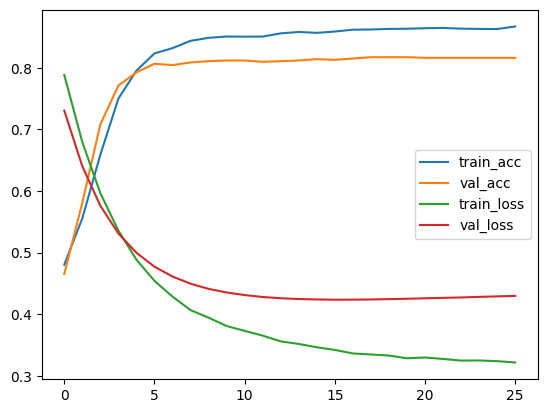

In [83]:
# Ensembling 3 models using another model
def ensemble(models):
    # Freeze the layers of each model
    for model in models:
        for layer in model.layers:
            layer.trainable = False
    # Get layer before the output layer for each model
    outputs = [model.layers[-2].output for model in models]

    # Concatenate the outputs
    combined = Concatenate()(outputs)

    # Add a Dense layer with 16 units
    x = Dense(16, activation='relu')(combined)
    x = Dropout(0.3)(x)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(combined)

    # Build the ensemble model
    ensemble_model = Model(inputs=[model.input for model in models], outputs=output_layer)

    # Compile the model
    ensemble_model.compile(optimizer=Adam(learning_rate=0.0001),
                           loss=BinaryCrossentropy(),
                           metrics=['accuracy'])
    
    return ensemble_model

set_seed(4)

# Assuming inception_model, res_model, and simple_model each have two inputs: X_train_num and X_train_embeddings
models = [inception_model, res_model, simple_model]
ensemble_model = ensemble(models)

# Fit the ensemble model
history = ensemble_model.fit([X_train_num, X_train_embeddings, X_train_num, X_train_embeddings, X_train_num, X_train_embeddings], 
                             y_train, 
                             epochs=1000, 
                             batch_size=64, 
                             verbose=1,
                             validation_data=([X_val_num, X_val_embeddings, X_val_num, X_val_embeddings, X_val_num, X_val_embeddings], y_val),
                             callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

plot(history)




In [84]:
def evaluate_ensemble_model(ensemble_model, X_test_num, X_test_embeddings, y_test):
    y_pred_probs = ensemble_model.predict([X_test_num, X_test_embeddings, X_test_num, X_test_embeddings, X_test_num, X_test_embeddings])
    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = y_test
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    print(f'Accuracy: {accuracy}')
    print(f'MCC: {mcc}')
    print(f'AUC: {auc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Specificity: {specificity}')
    print(f'F1: {f1}')

    return accuracy, mcc, auc, precision, recall, specificity, f1

# Call the function
evaluate_ensemble_model(ensemble_model, X_val_num, X_val_embeddings, y_val)
evaluate_ensemble_model(ensemble_model, X_test_num, X_test_embeddings, y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy: 0.8128342245989305
MCC: 0.6241668925794869
AUC: 0.8116835128113324
Precision: 0.8170974155069582
Recall: 0.8319838056680162
Specificity: 0.7913832199546486
F1: 0.8244734202607823
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7870517296096478
MCC: 0.36114073992643825
AUC: 0.799942015941289
Precision: 0.23629719853836784
Recall: 0.8151260504201681
Specificity: 0.7847579814624099
F1: 0.3663833805476865


(0.7870517296096478,
 0.36114073992643825,
 0.799942015941289,
 0.23629719853836784,
 0.8151260504201681,
 0.7847579814624099,
 0.3663833805476865)